In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_HSDM_2D(a, mu, ndt, sigma_a, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    
    rt = 0
    
    while np.linalg.norm(x, 2) < a(rt):
        x += mu*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1, mu.shape)
        rt += dt
    
    theta = np.arctan2(x[1], x[0])   
    alpha = -np.abs(np.random.normal(0.3, 0.1))
    return ndt+rt, theta, alpha, np.random.normal(alpha + ndt, sigma_a)

In [3]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            if a(j*dt) == 0:
                continue
            
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [4]:
def HSDM_2D_likelihood(prms, RT, Theta, Z, Residual):
    a = lambda t: prms[0]/(1 + prms[1]*t)
    a2 = lambda t: (a(t))**2
    da2 = lambda t: -2*prms[1]*prms[0]/(1 + prms[1]*t)**2 * a(t)
    
    ndt = prms[2]
    mu = np.array([prms[3], prms[4]])
    sig_z = prms[5]
    alpha = prms[6]
    sig_alpha = prms[7]
    
    sig = np.sqrt(sig_z**2 + sig_alpha**2)
        
    T_max = max(RT)
    fpt = ie_bessel_fpt(a2, da2, mu.shape[0], 0.000001, 
                        dt=0.05, T_max=T_max)
        
    log_lik = 0
    for i in range(len(RT)):
        rt, theta = RT[i], Theta[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            mu_dot_x0 = mu[0]*np.cos(theta)
            mu_dot_x1 = mu[1]*np.sin(theta)
            term1 = a(rt - ndt) * (mu_dot_x0 + mu_dot_x1)
            term2 = 0.5 * np.linalg.norm(mu, 2)**2 * (rt - ndt)
            

            density = np.exp(term1 - term2) * fpt(rt - ndt)
            
            log_lik += 0.5*(Z[i] - ndt - alpha)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            log_lik += 0.5*(Residual[i] - alpha)**2/sig_alpha**2 + 0.5*np.log(2*np.pi*sig_alpha**2)
            
            if 0.1**14 < density:
                log_lik += -np.log(density) 
            else:
                log_lik += -np.log(0.1**14) 
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [5]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': [],
                'mu2_true': [],
                'mu2_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[]}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = -3
max_mu = 3

In [56]:
for n in tqdm(range(5)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = np.random.uniform(min_lambda, max_lambda)
    a = lambda t: b0 /(1 + lamb*t)
    
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu), 
                   np.random.uniform(min_mu, max_mu)])
    
    sigma_a = np.random.uniform(0.05, 0.2)
    
    RT = []
    Theta = []
    Z = []
    Residual = []
    
    for i in range(500):
        rt, theta, alpha, z = simulate_HSDM_2D(a, mu, ndt, sigma_a)
        RT.append(rt)
        Theta.append(theta)
        Z.append(z)
        Residual.append(alpha)
    
    min_ans = differential_evolution(HSDM_2D_likelihood,
                                     args=(RT, Theta, Z, Residual),
                                     bounds=[(min_b0, max_b0), (min_lambda, max_lambda), 
                                             (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                                             (0.05, 0.2), (-1, -0.01), (0.05, 0.2)])
    
    min_ans = minimize(HSDM_2D_likelihood,
                       args=(RT, Theta, Z, Residual),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=[(min_b0, max_b0), (min_lambda, max_lambda),
                               (min_ndt, max_ndt), (min_mu, max_mu), (min_mu, max_mu),
                               (0.05, 0.2), (-1, -0.01), (0.05, 0.2)])
    
    if min_ans.success:
        recovery_dic['b0_true'].append(b0)
        recovery_dic['lambda_true'].append(lamb)
        recovery_dic['ndt_true'].append(ndt)
        recovery_dic['mu1_true'].append(mu[0])
        recovery_dic['mu2_true'].append(mu[1])
        recovery_dic['sigma_true'].append(sigma_a)

        recovery_dic['b0_estimate'].append(min_ans.x[0])
        recovery_dic['lambda_estimate'].append(min_ans.x[1])
        recovery_dic['ndt_estimate'].append(min_ans.x[2])
        recovery_dic['mu1_estimate'].append(min_ans.x[3])
        recovery_dic['mu2_estimate'].append(min_ans.x[4])
        recovery_dic['sigma_estimate'].append(min_ans.x[5])

100%|████████████████████████████████████████████████████| 5/5 [13:17<00:00, 159.48s/it]


In [57]:
recovery_df = pd.DataFrame(recovery_dic)
recovery_df.corr()

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
b0_true,1.000000,0.961873,0.127315,0.047351,0.020456,0.021307,0.155294,0.162045,-0.098634,-0.099517,-0.014812,0.005120
b0_estimate,0.961873,1.000000,0.165248,0.146622,0.092255,0.091558,0.159124,0.165882,-0.114500,-0.115766,-0.027712,-0.006129
lambda_true,0.127315,0.165248,1.000000,0.962104,-0.089405,-0.091282,0.010680,0.003638,0.039233,0.033005,-0.347712,-0.338873
lambda_estimate,0.047351,0.146622,0.962104,1.000000,-0.050224,-0.052738,0.010568,0.000245,0.009270,0.004923,-0.343114,-0.335323
ndt_true,0.020456,0.092255,-0.089405,-0.050224,1.000000,0.999651,-0.010059,-0.005249,0.342588,0.339800,-0.186310,-0.182984
ndt_estimate,0.021307,0.091558,-0.091282,-0.052738,0.999651,1.000000,-0.012397,-0.007700,0.341755,0.339013,-0.186101,-0.182664
mu1_true,0.155294,0.159124,0.010680,0.010568,-0.010059,-0.012397,1.000000,0.999117,-0.096995,-0.102393,-0.076308,-0.075402
mu1_estimate,0.162045,0.165882,0.003638,0.000245,-0.005249,-0.007700,0.999117,1.000000,-0.098014,-0.103876,-0.075740,-0.073536
mu2_true,-0.098634,-0.114500,0.039233,0.009270,0.342588,0.341755,-0.096995,-0.098014,1.000000,0.999130,-0.134157,-0.109953
mu2_estimate,-0.099517,-0.115766,0.033005,0.004923,0.339800,0.339013,-0.102393,-0.103876,0.999130,1.000000,-0.139525,-0.116562


In [58]:
recovery_df

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
0,2.466611,2.481197,1.448680,1.402435,0.566717,0.570225,-1.712836,-1.716879,0.678590,0.757892,0.062931,0.063674
1,3.696973,3.809266,1.113399,1.191375,0.899952,0.902372,1.867066,1.868662,1.969410,1.854703,0.052172,0.062789
2,4.677277,5.000000,0.154008,0.238213,0.427499,0.437339,1.504444,1.465556,1.813251,1.784404,0.161178,0.157577
3,3.172326,3.494783,1.348403,1.757675,0.475852,0.478036,1.595853,1.531033,-2.679074,-2.609545,0.160724,0.149726
4,3.346741,3.445027,1.983172,2.000000,0.478963,0.488639,2.930483,3.000000,-2.812554,-3.000000,0.090086,0.094715
5,2.225421,2.535800,1.150971,1.497545,0.303748,0.304095,-2.269576,-2.261087,-1.444993,-1.459268,0.130022,0.139102
6,2.859909,3.020028,0.775733,0.876762,0.848142,0.849391,-1.823566,-1.801118,1.958321,2.019326,0.068948,0.070399
7,2.650593,2.733185,0.562040,0.598737,0.558925,0.562909,0.359970,0.374526,-0.194223,-0.187256,0.146857,0.173540
8,3.777532,4.040783,0.824016,0.829927,0.136760,0.129213,1.392678,1.459943,-2.865068,-3.000000,0.194136,0.200000
9,2.525432,2.851489,0.701989,0.980346,0.529046,0.527419,1.454013,1.446738,2.394381,2.361623,0.122146,0.120266


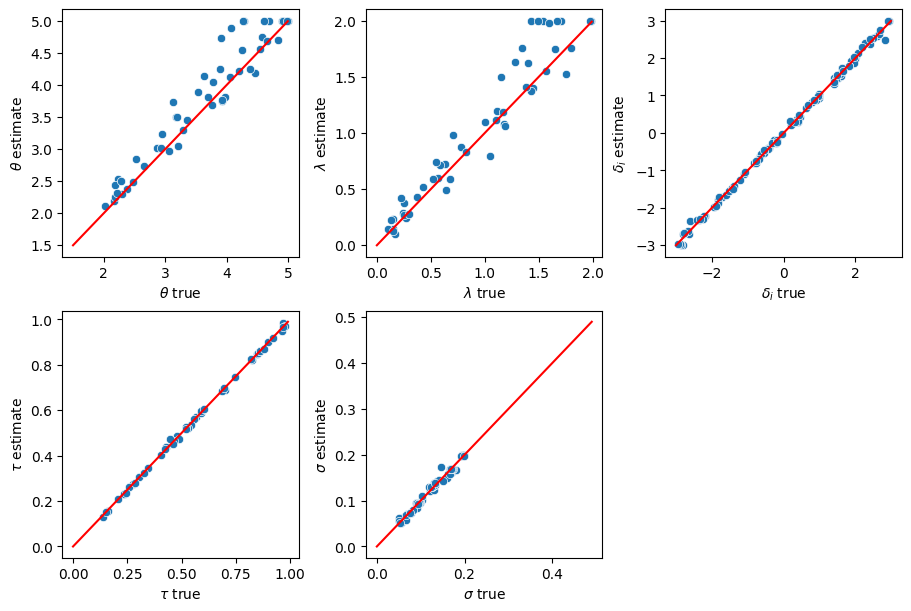

In [59]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 5, 0.01), np.arange(1.5, 5, 0.01), c='red')
sns.scatterplot(x='b0_true', y='b0_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(-3, 3, 0.01), np.arange(-3, 3, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);
sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df, c='tab:blue');
plt.xlabel(r'$\delta_i$ true')
plt.ylabel(r'$\delta_i$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');

plt.subplot(235)
plt.plot(np.arange(0, .5, 0.01), np.arange(0, .5, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');

In [60]:
recovery_df.corr()

,b0_true,b0_estimate,lambda_true,lambda_estimate,ndt_true,ndt_estimate,mu1_true,mu1_estimate,mu2_true,mu2_estimate,sigma_true,sigma_estimate
b0_true,1.000000,0.961873,0.127315,0.047351,0.020456,0.021307,0.155294,0.162045,-0.098634,-0.099517,-0.014812,0.005120
b0_estimate,0.961873,1.000000,0.165248,0.146622,0.092255,0.091558,0.159124,0.165882,-0.114500,-0.115766,-0.027712,-0.006129
lambda_true,0.127315,0.165248,1.000000,0.962104,-0.089405,-0.091282,0.010680,0.003638,0.039233,0.033005,-0.347712,-0.338873
lambda_estimate,0.047351,0.146622,0.962104,1.000000,-0.050224,-0.052738,0.010568,0.000245,0.009270,0.004923,-0.343114,-0.335323
ndt_true,0.020456,0.092255,-0.089405,-0.050224,1.000000,0.999651,-0.010059,-0.005249,0.342588,0.339800,-0.186310,-0.182984
ndt_estimate,0.021307,0.091558,-0.091282,-0.052738,0.999651,1.000000,-0.012397,-0.007700,0.341755,0.339013,-0.186101,-0.182664
mu1_true,0.155294,0.159124,0.010680,0.010568,-0.010059,-0.012397,1.000000,0.999117,-0.096995,-0.102393,-0.076308,-0.075402
mu1_estimate,0.162045,0.165882,0.003638,0.000245,-0.005249,-0.007700,0.999117,1.000000,-0.098014,-0.103876,-0.075740,-0.073536
mu2_true,-0.098634,-0.114500,0.039233,0.009270,0.342588,0.341755,-0.096995,-0.098014,1.000000,0.999130,-0.134157,-0.109953
mu2_estimate,-0.099517,-0.115766,0.033005,0.004923,0.339800,0.339013,-0.102393,-0.103876,0.999130,1.000000,-0.139525,-0.116562
